[View in Colaboratory](https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_03/Assignment_03.ipynb)

# Required Libraries

# Libraries & Standard Setup

In [44]:
!pip install jupyterthemes

In [0]:
%matplotlib inline

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt  # for root mean-squared error calculation

# Learning Libraries
import sklearn.linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# jt themes
from jupyterthemes import jtplot

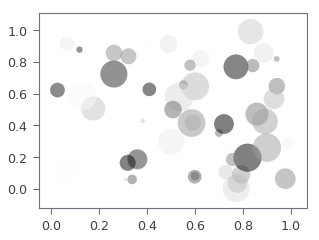

In [55]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

# Dataset

In [0]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/bmoretz/MSDS-MachineLearning/master/Assignment_03"
DATA_PATH = "datasets"
DATA_FILE = "boston.csv"
FILE_URL = "{}/{}/{}".format(DOWNLOAD_ROOT, DATA_PATH, DATA_FILE)

# Where to save the figures
PROJECT_ROOT_DIR = "./images/"

RANDOM_SEED = 1

In [0]:
boston = pd.read_csv(FILE_URL)

# Standard Library

In [0]:
# santatize Dataset
def santatize_set( dataframe ):
    if dataframe.isnull().values.any() == True:
        cleaned = dataframe.dropna()
        print('Dropped {} invalid samples'.format(dataframe.count - cleaned.count))
        dataframe = cleaned
    return dataframe

In [37]:
boston.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [38]:
boston.tail()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0


In [39]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
neighborhood    506 non-null object
crim            506 non-null float64
zn              506 non-null float64
indus           506 non-null float64
chas            506 non-null int64
nox             506 non-null float64
rooms           506 non-null float64
age             506 non-null float64
dis             506 non-null float64
rad             506 non-null int64
tax             506 non-null int64
ptratio         506 non-null float64
lstat           506 non-null float64
mv              506 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.4+ KB


In [56]:
boston.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


# Exploratory Data Analysis